# **Wikiwomen: An analysis on gender bias**
*metADAta*

We begin with taking a look at the Wikispeedia dataset and importing the files from it. The dataframe `female` is an additional dataset that we constructed ourselves.

### **Dataframes: Columns and descriptions**

| Name of dataframe | Columns                                                         | Description                                                                   |   |   |
|-------------------|-----------------------------------------------------------------|-------------------------------------------------------------------------------|---|---|
| articles          | [article]                                                       | Contains the name of a wikispeedia article                                    |   |   |
| categories        | [article, category]                                             | Contains the name of a wikispeedia article and its corresponding category     |   |   |
| links             | [link_source, link_target]                                      | Contains the source and target article between links         |   |   |
| paths_finished    | [hashedIpAddress, timestamp, durationInSec, path, rating]       | Contains all finished paths                                                   |   |   |
| paths_unfinished  | [hashedIpAddress, timestamp, durationInSec, path, target, type] | Contains all unfinished paths. Type refers to the reason they were unfinished |   |   |
| shortest_distance_text  | array | Every row corresponds to a source article, in the same order as they appear in *articles*, and its value contains the shortest distance from that source article to every other article.  |   |   |
| female  | [name, womenLabel] | Contains a list of articles about females and their corresponding subcategory |   |   |

## **Importing the data**

In [527]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats

In [528]:
DATA_FOLDER = 'data/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
SHORTEST_PATHS = WIKISPEEDIA_PATHS + "shortest-path-distance-matrix.txt"
FEMALES = DATA_FOLDER + "listwomen.txt"

In [529]:
articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt(SHORTEST_PATHS, dtype=str, comments="#", unpack=False)
female = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)

## **Pre-processing and dataset construction**

For our project, we are mainly interested in one category within the Wikispeedia dataset, namely the category of People, the one colored red in the following bar plot. 

In [530]:
main_categories = pd.concat([categories, categories['category'].str.split(".", expand=True)], axis=1)
main_categories = main_categories.drop(columns = ["category", 0, 2, 3])
main_categories = main_categories.rename(columns = {"article": "name", 1: "main_category"})

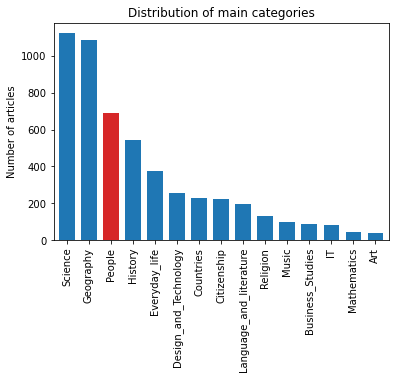

In [531]:
# plotting the distribution of main_categories
maincategories_dist = main_categories["main_category"].value_counts()
colors = ['tab:red' if (x == "People") else 'tab:blue' for x in maincategories_dist.keys()]
maincategories_dist.plot.bar(title = "Distribution of main categories",
                             ylabel = 'Number of articles', 
                             color = colors,
                             width = 0.7)
plt.show()

We will now take a closer look of the articles and their subcategories within the People category.

In [532]:
# finding the articles that are in the People category
categories["category_people"] = categories["category"].apply(lambda x: x.startswith('subject.People.'))

# constructing a new dataframe called people, only with articles from the people category
people = categories[categories["category_people"] == True]

# splitting the categories into main- and subcategories
people = pd.concat([people, people['category'].str.split(".", expand=True)], axis=1)
people = people.drop(columns = ["category_people", "category", 0, 1])
people = people.rename(columns = {"article":"name", 2:"category"})

The number of articles about people are 689


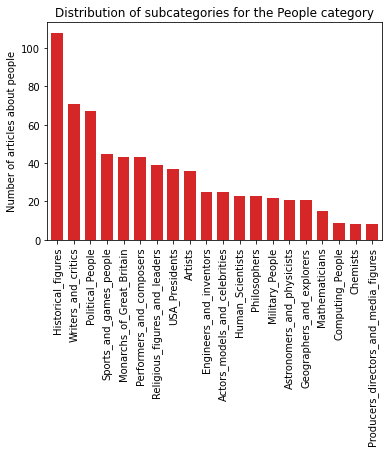

In [533]:
print(f"The number of articles about people are {len(people)}")

# plotting the distribution of subcategories within the People category
subcategories_dist = people["category"].value_counts()
subcategories_dist.plot.bar(title = "Distribution of subcategories for the People category",
                            ylabel = 'Number of articles about people', 
                            color = "tab:red", width = 0.7)
plt.show()

For our project goals, we need to be able to identify between women and men articles. In the following cells, we will do so by using the `female` dataframe, as well as finding every node degree, i.e., every number of incoming and outcoming links from every article.

In [534]:
# identify women and men in people
people["gender"] =  people['name'].isin(female["name"])
people["gender"] = people["gender"].apply(lambda x: "female" if x else "male")

# counting in- and out-links for every article
count_links_src = links.link_source.value_counts()
count_links_target = links.link_target.value_counts()

# drop all people that have no in_link -> impossible to reach the article
people = people.merge(count_links_src, how = "left", left_on = "name", right_index = True)
people = people.merge(count_links_target, how = "inner", left_on = "name", right_index = True)
people = people.rename(columns = {"link_source": "nr_link_out", "link_target": "nr_link_in"})
people.head()

,name,category,gender,nr_link_out,nr_link_in
95,Abel_Tasman,Geographers_and_explorers,male,14,5
105,Abraham_Lincoln,USA_Presidents,male,35,62
129,Adam_Smith,Historical_figures,male,27,38
134,Adolf_Hitler,Political_People,male,78,109
159,Agamemnon,Historical_figures,male,11,9


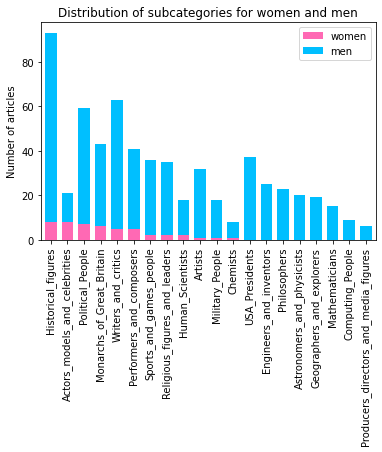

In [535]:
women_people = people[people['gender'] == "female"]["category"].value_counts()
men_people = people[people['gender'] == "male"]["category"].value_counts()
index = men_people.keys()
men_women_cat = pd.DataFrame({'women': women_people,'men': men_people}, index=index).sort_values(by = ["women"], ascending = False)
ax = men_women_cat.plot.bar(stacked = True, color = ['hotpink', 'deepskyblue'], 
                            title = "Distribution of subcategories for women and men",
                            ylabel = 'Number of articles', width = 0.7)
plt.show()

Now, we will construct a new dataframe called `path_overview` that contains the following columns:

| **Column_name**      | **Description**                                                     |
|----------------------|---------------------------------------------------------------------|
| source               | Source article of navigated path                                    |
| target               | Target article of navigated path                                    |
| finished             | True if path was finished, false otherwise                          |
| human_path_length    | The length of the path it took the user to go from source to target |
| shortest_path_length | Shortest possible path from a source to a target                    |
| path_deviation       | The difference between human_path_length and shortest_path_lenght   |
| playtime             | Duration of game                                                    |
| type                 | Reason for unfinished game                                          |
| failure_article      | Title of article where game was failed (unfinished)                 |
| difficulty_rating    | Difficulty rating done by players                                   |
| number_backclicks    | Number of backclicks in a path                                      |

In [536]:
def process_path(path):
    '''
    Decompose a path and find its length. 
    Assumption: When back-clicks are encountered, we increase the path length by 1.
    :param path: a full-length path
    :return: source, target, length, number_backclicks
    '''
    p = path.split(";")
    number_backclicks = p.count('<')
    source = p[0]
    target = p[-1]
    length = len(p)
    return source, target, length, number_backclicks

In [537]:
# expand the finished paths 
path_fin = paths_finished.copy()
path_fin["source"], path_fin["target"],path_fin["human_path_length"], path_fin["number_backclicks"] = zip(*paths_finished['path'].apply(lambda x: process_path(x)))
path_fin["finished"] = True

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin["source"], path_ufin["failure_article"], path_ufin["human_path_length"], path_ufin["number_backclicks"]= zip(*paths_unfinished['path'].apply(lambda x: process_path(x)))
path_ufin["finished"] = False
path_ufin['target'] = paths_unfinished["target"]

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)    
path_overview = path_overview.rename(columns={"durationInSec": "playtime_sec", "rating": "difficulty_rating"})
path_overview["playtime_min"] = path_overview["playtime_sec"]/60
path_overview = path_overview[["source", "target", "finished", "human_path_length", 
                               "playtime_sec", "playtime_min", "type", "failure_article", "difficulty_rating","number_backclicks",
                               "hashedIpAddress", "timestamp"]]

**Finding the shortest path length and adding it to `path_overview`:**

We begin with creating a matrix with the shortest path length information from the imported file *shortest-path-distance-matrix.txt*:

In [538]:
# The Shortest Distance Matrix is created from the imported data
shortest_distance_matrix = [] 
for row in shortest_distance_text:
    row_formated = [] 
    for c in row:
        if c.isdigit(): 
            row_formated.append(int(c))
        else:
            row_formated.append(-1) ## If there is no path between two articles it's represented with -1
        
    shortest_distance_matrix.append(np.array(row_formated))

shortest_distance_matrix = np.array(shortest_distance_matrix)

We make sure that paths with target articles that don't exist are deleted:

In [539]:
condition = ~(path_overview['target'].isin(articles['article'].array))
path_overview = path_overview.drop(path_overview[condition].index)

Now we define a function that accesses the corresponding short distance value of a source and target pair in the matrix `shortest_distance_matrix`:

In [540]:
def get_shortest_distance(source, target, help_articles):
    '''
    Finding the shortest path length between a source and a target
    :param source: source article 
    :param target: target article
    :param help_articles: a helper dataframe where article and index are changed
    :return: shortest_distance_matrix value for source and target article
    '''
    source_idx = help_articles.loc[source]
    target_idx = help_articles.loc[target]
    return shortest_distance_matrix[source_idx,target_idx][0]

Calling the function, we can add the shortest path length to `path_overview`:

In [541]:
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
path_overview["shortest_path_length"] = path_overview.apply(lambda x: get_shortest_distance(x["source"], x["target"], 
                                                                                            help_articles), axis = 1)

Below, we remove all infeasible paths, i.e., all source and target pairs that have a shortest path length value of -1:

In [542]:
path_overview = path_overview.drop(path_overview[path_overview['shortest_path_length'] < 0].index) 
path_overview.insert(4, 'shortest_path_length', path_overview.pop('shortest_path_length'))
path_overview

,source,target,finished,human_path_length,shortest_path_length,playtime_sec,playtime_min,type,failure_article,difficulty_rating,number_backclicks,hashedIpAddress,timestamp
0,14th_century,African_slave_trade,True,9,3,166,2.766667,NaN,NaN,NaN,0,6a3701d319fc3754,1297740409
1,14th_century,African_slave_trade,True,5,3,88,1.466667,NaN,NaN,3.0,0,3824310e536af032,1344753412
2,14th_century,African_slave_trade,True,8,3,138,2.300000,NaN,NaN,NaN,0,415612e93584d30e,1349298640
3,14th_century,Greece,True,4,2,37,0.616667,NaN,NaN,NaN,0,64dd5cd342e3780c,1265613925
4,14th_century,John_F._Kennedy,True,7,3,175,2.916667,NaN,NaN,3.0,0,015245d773376aab,1366730828
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76188,Franz_Kafka,Cholera,False,8,3,180,3.000000,restart,Ghana,NaN,1,109ed71f571d86e9,1389787605
76189,Modern_history,Hollandic,False,1,3,6,0.100000,restart,Modern_history,NaN,0,232f992e57d43e8d,1389787697
76190,Computer_programming,The_Beatles,False,5,3,1900,31.666667,timeout,<,NaN,1,2e09a7224600a7cd,1389798400
76191,Jamaica,Alan_Turing,False,4,3,1903,31.716667,timeout,Battle_of_Midway,NaN,0,60af9e2138051b96,1389799481


Now, we can add the column `path_deviation` to our dataframe, which is the difference between the `human_path_length` and the `shortest_path_length`. We also remove all rows that have a negative value of path deviation, since a human path length can not be smaller than the shortest path length.

In [543]:
# add path_deviation to path_overview
path_overview["path_deviation"] = path_overview["human_path_length"] - path_overview["shortest_path_length"]

# we remove all rows that have a negative path_dev
path_overview = path_overview.drop(path_overview.index[path_overview['path_deviation'] < 0])
path_overview.insert(5, 'path_deviation', path_overview.pop('path_deviation'))
path_overview

,source,target,finished,human_path_length,shortest_path_length,path_deviation,playtime_sec,playtime_min,type,failure_article,difficulty_rating,number_backclicks,hashedIpAddress,timestamp
0,14th_century,African_slave_trade,True,9,3,6,166,2.766667,NaN,NaN,NaN,0,6a3701d319fc3754,1297740409
1,14th_century,African_slave_trade,True,5,3,2,88,1.466667,NaN,NaN,3.0,0,3824310e536af032,1344753412
2,14th_century,African_slave_trade,True,8,3,5,138,2.300000,NaN,NaN,NaN,0,415612e93584d30e,1349298640
3,14th_century,Greece,True,4,2,2,37,0.616667,NaN,NaN,NaN,0,64dd5cd342e3780c,1265613925
4,14th_century,John_F._Kennedy,True,7,3,4,175,2.916667,NaN,NaN,3.0,0,015245d773376aab,1366730828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76187,Turks_and_Caicos_Islands,Iraq_War,False,6,3,3,182,3.033333,restart,War,NaN,0,109ed71f571d86e9,1389787212
76188,Franz_Kafka,Cholera,False,8,3,5,180,3.000000,restart,Ghana,NaN,1,109ed71f571d86e9,1389787605
76190,Computer_programming,The_Beatles,False,5,3,2,1900,31.666667,timeout,<,NaN,1,2e09a7224600a7cd,1389798400
76191,Jamaica,Alan_Turing,False,4,3,1,1903,31.716667,timeout,Battle_of_Midway,NaN,0,60af9e2138051b96,1389799481


In [544]:
# save dataframe to file
path_overview.to_csv("./data/all_paths_overview.csv")

In [545]:
people.columns

Index(['name', 'category', 'gender', 'nr_link_out', 'nr_link_in'], dtype='object')

Let's turn our attention to all people, and identify the paths in `path_overview` that only have people as target article:

In [546]:
# find only targets that are people
people_target_paths = path_overview.merge(people[['name', 'category', 'gender', "nr_link_in"]], 
                                          how = "inner", left_on = "target", right_on = "name")

Preparing for the matching of the In degree. Since the number of unique In Degrees is 77, we decided to create 10 equally sized groups, and mapping the values to these ten groups.

In [547]:
people_target_paths["in_degree_rep"] = pd.cut(people_target_paths["nr_link_in"], bins=10, labels=np.arange(1,11,1))

We can then find all paths that have women-targets and all paths that have men-targets:

In [548]:
# find only targets that are women
women_target_paths = people_target_paths[people_target_paths['gender'] == "female"]
print(f"The number of paths that have women as a target article is {len(women_target_paths)}")

The number of paths that have women as a target article is 560


In [549]:
# find only targets that are men
men_target_paths = people_target_paths[people_target_paths['gender'] == "male"]
print(f"The number of paths that have men as a target article is {len(men_target_paths)}")

The number of paths that have men as a target article is 7187


**A closer look of men vs. women articles**

In [550]:
women = len(people_target_paths[people_target_paths['gender'] == "female"])
men = len(people_target_paths[people_target_paths['gender'] == "male"])
women_finished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == True)])
men_finished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == True)])
women_unfinished = len(people_target_paths[(people_target_paths['gender'] == "female") & (people_target_paths['finished'] == False)])
men_unfinished = len(people_target_paths[(people_target_paths['gender'] == "male") & (people_target_paths['finished'] == False)])

print(f"Number of paths with a woman as a target {women} ({(women/(women+men))*100:.2f} % (of paths with a target related to a person))")
print(f"Number of paths with a man as a target {men} ({(men/(women+men))*100:.2f} %)")
print()
print(f"Number of finished paths with a woman as a target {women_finished} ({(women_finished/(women_finished+men_finished))*100:.2f}%)")
print(f"Number of finished paths with a man as a target {men_finished} ({(men_finished/(women_finished+men_finished))*100:.2f}%)")
print()
print(f"Number of unfinished paths with a woman as a target {women_unfinished} ({(women_unfinished/(women_unfinished+men_unfinished))*100:.2f}%)")
print(f"Number of unfinished paths with a man as a target {men_unfinished} ({(men_unfinished/(women_unfinished+men_unfinished))*100:.2f}%)")

Number of paths with a woman as a target 560 (7.23 % (of paths with a target related to a person))
Number of paths with a man as a target 7187 (92.77 %)

Number of finished paths with a woman as a target 347 (5.71%)
Number of finished paths with a man as a target 5727 (94.29%)

Number of unfinished paths with a woman as a target 213 (12.73%)
Number of unfinished paths with a man as a target 1460 (87.27%)


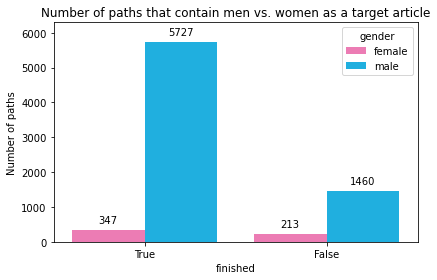

In [551]:
ax = sns.countplot( data=people_target_paths, x = "finished", hue="gender", 
                    order = [True,False], hue_order=["female","male"], palette = ['hotpink','deepskyblue'])
 
ax.set_title('Number of paths that contain men vs. women as a target article')
ax.set_ylabel("Number of paths")
ax.margins(y=0.1) # make room for the labels
for bars in ax.containers:
    ax.bar_label(bars, padding = 5)
plt.tight_layout()
plt.show()

To compute the success rate of finishing a path with a certain target article, we will count how many times a game with a certain target article was finished, and divide it with the total number of paths where it was the target:

In [552]:
# count total, finished and unfinished number of times a target article was reached
tot_target = people_target_paths.target.value_counts().rename("tot_target_count")
fin_target = people_target_paths[people_target_paths['finished'] == True].target.value_counts().rename("fin_target_count")
unf_target = people_target_paths[people_target_paths['finished'] == False].target.value_counts().rename("unf_target_count")

# add this information to the people dataframe
people = people.merge(tot_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(unf_target, how = "left",  left_on = "name", right_index = True)
people = people.merge(fin_target, how = "left",  left_on = "name", right_index = True)

In [553]:
# compute success rate of finishing a path
# people['tot_target_count'] = people['tot_target_count'].fillna(0)
# people['fin_target_count'] = people['fin_target_count'].fillna(0)
# people['unf_target_count'] = people['unf_target_count'].fillna(0)
people['succ_rate'] = people['fin_target_count']/people['tot_target_count']
# people['succ_rate'] = people['succ_rate'].fillna(0)

In [554]:
people.to_csv("./data/people_overview.csv")

## **Statistical analysis**

### **Naive analysis** 

The first step of our data analysis will be a naive statistical analysis, where we will check for differences in the following metrics:

- **success_rate**
- **in_degree**
- **playtime**
- **path_deviation**
- **number_backclicks** 
- **difficulty_rating**

These differences will be checked for significance using bootstrap confidence intervals.

A helpful function to plot two histograms on the same plot and gain a quick overview over the underlying distribution:

In [555]:
def plot_2_dist(column, dataframe, bins = np.array([]), my_title = "", my_xlabel = "", my_ylabel = "", ylog=False, xlog=False):
    '''
    Plot two histograms with a vertical line that describes the median of the metric.
    :param column: metric to be plotted
    :param dataframe: from which dataframe the metric comes from
    :param bins: number of bins
    :param my_title: set the title of the plot
    :param my_xlabel: set the x label of the plot
    :param my_ylabel: set the y label of the plot
    :param ylog: set to True if you wish to plot the histogram with a log-scale
    :return: plot
    '''
    female = dataframe[dataframe["gender"]== "female"][column]
    male = dataframe[dataframe["gender"]== "male"][column]
    
    # let's first check the distribution of both the male and the female data available
    if bins.size == 0:
        bins = np.arange(min(female)-0.5, max(female) + 0.5, 1)
    # plot the male distribution of the metric
    plt.hist(male, 
            color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.5,
            bins= bins, label ="male")
    # plot the female distribution of the metric
    plt.hist(female, 
            color = 'tab:red', edgecolor = 'black', linewidth = 0.5, alpha=0.5, 
            bins= bins, label ="female")
    plt.xlabel(my_xlabel)
    plt.ylabel(my_ylabel)
    if ylog:
        plt.yscale('log')
    if xlog:
        plt.xscale('log')
    plt.title(my_title)
    # add a vertical line that describes the median of the metric
    plt.axvline(np.median(female), color="tab:red")
    plt.axvline(np.median(male),color="tab:blue")
    plt.legend()
    plt.show()

#### **Success rate**

Success rate bootstrapping with all success rate values (including zeros) which skewes our results:

In [556]:
def bootstrap_metric(metric, dataframe:pd.DataFrame, gender,summary:pd.DataFrame = pd.DataFrame(), estimator = "Geometric", remove_zero = True, ci = 0.95):
    if remove_zero:
        ### For simplicities sakes, we remove the zero values of the metric
        dataframe = dataframe[dataframe[metric] > 0]
        data = dataframe[dataframe["gender"]== gender][metric]
    else:
        data = dataframe[dataframe["gender"]== gender][metric]
    
    data_bootstrap = (data.dropna().to_numpy(),)
    
    if estimator =="Geometric":
        geom_mean = stats.gmean(data.dropna().to_numpy(), dtype=None)
        print(f"{gender}: Geometric mean: {geom_mean}")
    
        # estimating the 95% CI of the geometric mean of the metric
        res_bootstrap_gm = stats.bootstrap(data_bootstrap, stats.gmean, confidence_level=ci)
        print(f"{gender}: {ci*100}% confidence interval of the geometric mean of {metric}: [{res_bootstrap_gm.confidence_interval[0]:.3f}, "
          f"{res_bootstrap_gm.confidence_interval[1]:.3f}]")
        if not summary.columns.empty:
          new_row = pd.Series({'gender': gender, "gmean": geom_mean, "ci_0": res_bootstrap_gm.confidence_interval[0],
                                    'ci_1': res_bootstrap_gm.confidence_interval[1], "metric": metric})
          summary = pd.concat([summary, new_row.to_frame().T], ignore_index=True)
        
        return summary

    elif estimator == "Arithmetic":
        arith_mean = data.mean()
        print(f"{gender}: Arithmetic mean: {arith_mean}")
    
        # estimating the 95% CI of the arithmetic mean of the metric
        res_bootstrap_am = stats.bootstrap(data_bootstrap, np.mean, confidence_level=ci)
        print(f"{gender}: {ci*100}% confidence interval of the arithmetic mean of {metric}: [{res_bootstrap_am.confidence_interval[0]:.3f}, "
          f"{res_bootstrap_am.confidence_interval[1]:.3f}]")
        return arith_mean

    elif estimator =="Median":
        median = np.median(data_bootstrap)
        print(f"{gender}: Median: {median}")
    
        # estimating the 95% CI of the arithmetic mean of the metric
        res_bootstrap_am = stats.bootstrap(data_bootstrap, np.median, confidence_level=ci)
        print(f"{gender}: {ci*100}% confidence interval of the Median of {metric}: [{res_bootstrap_am.confidence_interval[0]:.3f}, "
          f"{res_bootstrap_am.confidence_interval[1]:.3f}]")
        return median



Female articles: Success rate bootstrapping for all paths that are finished (no zeros)

In [557]:
wsuccessrate_mean = bootstrap_metric("succ_rate", people, "female", estimator= "Geometric", remove_zero=True)
msuccessrate_mean = bootstrap_metric("succ_rate", people, "male", estimator= "Geometric", remove_zero=True)

female: Geometric mean: 0.6068480390130131
female: 95.0% confidence interval of the geometric mean of succ_rate: [0.484, 0.700]
male: Geometric mean: 0.7758441073276038
male: 95.0% confidence interval of the geometric mean of succ_rate: [0.743, 0.802]


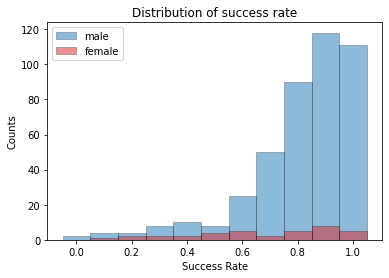

In [558]:
plot_2_dist("succ_rate", people, bins=  np.arange(0-0.05,1+0.15,0.1),
            my_title="Distribution of success rate", my_xlabel="Success Rate", my_ylabel="Counts")

This implies that there is a significant difference in the success rate of these two groups.

#### A few distribution plots for success rate:

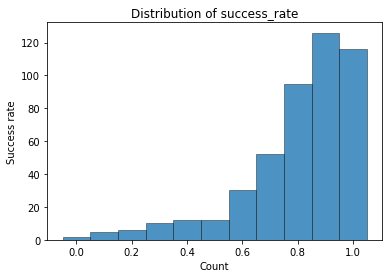

In [559]:
female = people["succ_rate"]
# plot the histogram
plt.hist(female, color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.8, bins= np.arange(0-0.05,1+0.15,0.1))
plt.xlabel("Count")
plt.ylabel("Success rate")
plt.title("Distribution of success_rate")
plt.show()

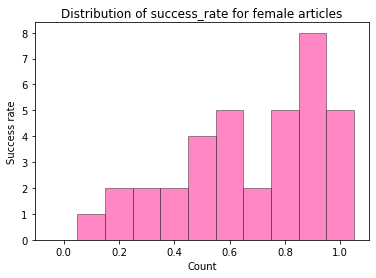

In [560]:
female = people[people["gender"]== "female"]["succ_rate"]
# plot the histogram
plt.hist(female, color = 'hotpink', edgecolor = 'black', linewidth = 0.5, alpha=0.8, bins= np.arange(0-0.05,1+0.15,0.1))
plt.xlabel("Count")
plt.ylabel("Success rate")
plt.title("Distribution of success_rate for female articles")
plt.show()

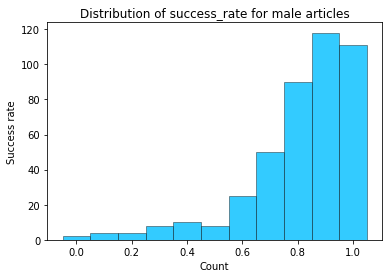

In [561]:
male = people[people["gender"]== "male"]["succ_rate"]
# plot the histogram
plt.hist(male, color = 'deepskyblue', edgecolor = 'black', linewidth = 0.5, alpha=0.8, bins= np.arange(0-0.05,1+0.15,0.1))
plt.xlabel("Count")
plt.ylabel("Success rate")
plt.title("Distribution of success_rate for male articles")
plt.show()

In [562]:
female_never_reached = people[people["gender"]== "female"]
female_never_reached = female_never_reached[female_never_reached["succ_rate"] == 0]
#female_never_reached.sort_values("succ_rate", ascending=True).head(50)
#unquote(female_never_reached['name'][929])
female_never_reached['name']

Series([], Name: name, dtype: object)

We would like to visualize the distribution of success within the male and female groups and for each of the categories. 

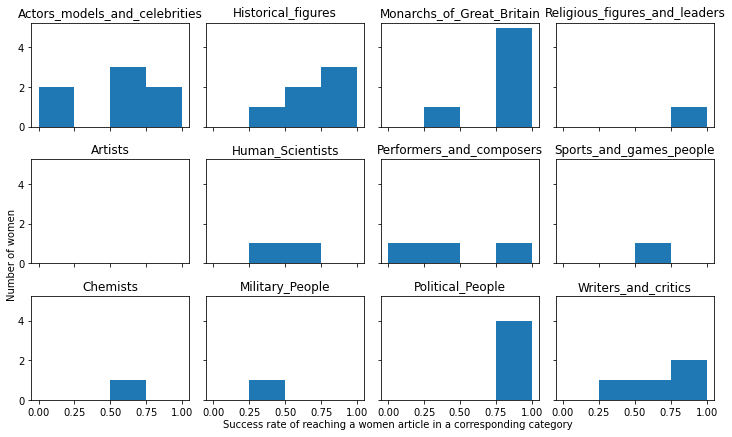

In [563]:
# Write your code to make 3x4 panel here
import math

women_by_cat = people[people["gender"]== "female"].groupby('category').apply(lambda x: pd.Series({
        'succ_rate': x['succ_rate'].values
    }))

fig, ax = plt.subplots(3,4,figsize= (10,6), sharey = True, sharex = True)

for i in range(12):
    sbplt = ax[i%3, math.floor(i/3)]
    sbplt.hist(women_by_cat.iloc[i].values, range = [0,1], bins = 4)
    sbplt.set_title(women_by_cat.index[i])
    
fig.tight_layout()

fig.text(0.3,0, "Success rate of reaching a women article in a corresponding category")
fig.text(0,0.3, "Number of women", rotation = 90)
plt.show()

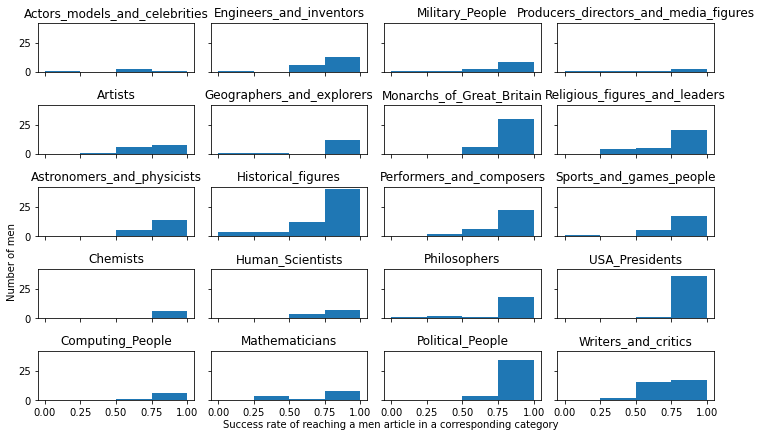

In [564]:
men_by_cat = people[people["gender"]== "male"].groupby('category').apply(lambda x: pd.Series({
        'succ_rate': x['succ_rate'].values
    }))

fig, ax = plt.subplots(5,4,figsize= (10,6), sharey = True, sharex = True)

for i in range(20):
    sbplt = ax[i%5, math.floor(i/5)]
    sbplt.hist(men_by_cat.iloc[i].values, range = [0,1], bins = 4)
    sbplt.set_title(men_by_cat.index[i])
    
fig.tight_layout()

fig.text(0.3,0, "Success rate of reaching a men article in a corresponding category")
fig.text(0,0.3, "Number of men", rotation = 90)
plt.show()

#### **Playtime**

**Playtime of only Finished articles**

In [565]:
wplaytime_mean = bootstrap_metric("playtime_min", people_target_paths[people_target_paths["finished"] == True], "female",
                                    estimator = "Geometric",remove_zero = True)
mplaytime_mean = bootstrap_metric("playtime_min", people_target_paths[people_target_paths["finished"] == True], "male", 
                                    estimator = "Geometric",remove_zero = True)

female: Geometric mean: 2.384064549174565
female: 95.0% confidence interval of the geometric mean of playtime_min: [2.180, 2.608]
male: Geometric mean: 1.686718392076239
male: 95.0% confidence interval of the geometric mean of playtime_min: [1.649, 1.724]


There is a significant difference in the playtime of finished articles between the two groups.

In [566]:
people_target_paths[people_target_paths["playtime_min"] == 0]

,source,target,finished,human_path_length,shortest_path_length,path_deviation,playtime_sec,playtime_min,type,failure_article,difficulty_rating,number_backclicks,hashedIpAddress,timestamp,name,category,gender,nr_link_in,in_degree_rep
3184,Florence_Nightingale,Florence_Nightingale,True,1,0,1,0,0.0,NaN,NaN,NaN,0,43f864c75b2571b5,1350587383,Florence_Nightingale,Human_Scientists,female,7,1
6095,William_and_Mary,William_and_Mary,True,1,0,1,0,0.0,NaN,NaN,NaN,0,43f864c75b2571b5,1350587414,William_and_Mary,Monarchs_of_Great_Britain,female,8,1
7272,Abel_Tasman,Abel_Tasman,True,1,0,1,0,0.0,NaN,NaN,NaN,0,43f864c75b2571b5,1350587367,Abel_Tasman,Geographers_and_explorers,male,5,1


Again, there is a significant difference of playtime between the two groups.

In [567]:
# plot_2_dist("playtime", people_target_paths[people_target_paths["finished"] == True], 
#             my_title="Distribution of playtime", my_xlabel="Playtime", my_ylabel="Counts", ylog=True, xlog=True)

#### **Path deviation**

**Path deviation of finished articles**

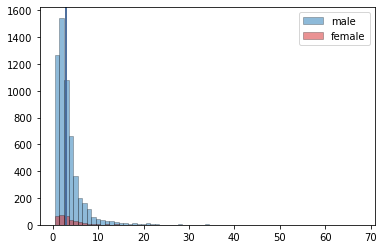

In [568]:
plot_2_dist("path_deviation",people_target_paths[people_target_paths["finished"] == True] )

In [569]:
wpathdev_mean = bootstrap_metric("path_deviation", people_target_paths[people_target_paths["finished"] == True], "female",
                                estimator= "Geometric", remove_zero = False)

mpathdev_mean = bootstrap_metric("path_deviation", people_target_paths[people_target_paths["finished"] == True], "male",
                                estimator= "Geometric", remove_zero = False)

female: Geometric mean: 3.1422912007889443
female: 95.0% confidence interval of the geometric mean of path_deviation: [2.895, 3.432]
male: Geometric mean: 2.6369112781430974
male: 95.0% confidence interval of the geometric mean of path_deviation: [2.590, 2.687]


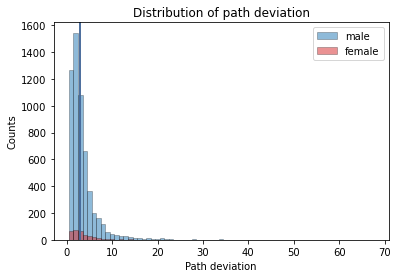

In [570]:
plot_2_dist("path_deviation", people_target_paths[people_target_paths["finished"] == True], 
            my_title="Distribution of path deviation", my_xlabel="Path deviation", my_ylabel="Counts")

There is a significant difference.

#### **Number of back clicks**

In [571]:
wback_mean = bootstrap_metric("number_backclicks", people_target_paths, "female")

mback_mean = bootstrap_metric("number_backclicks", people_target_paths, "male")

female: Geometric mean: 1.7940964206248158
female: 95.0% confidence interval of the geometric mean of number_backclicks: [1.622, 2.024]
male: Geometric mean: 1.7091503765956244
male: 95.0% confidence interval of the geometric mean of number_backclicks: [1.644, 1.779]


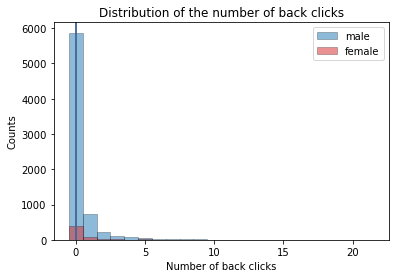

In [572]:
plot_2_dist("number_backclicks", people_target_paths, 
            my_title="Distribution of the number of back clicks", my_xlabel="Number of back clicks", my_ylabel="Counts")

#### **Difficulty rating**

In [573]:
wdiffrating_mean = bootstrap_metric("difficulty_rating", people_target_paths[people_target_paths["finished"] == True], "female")

mdiffrating_mean = bootstrap_metric("difficulty_rating", people_target_paths[people_target_paths["finished"] == True], "male")

female: Geometric mean: 2.2019182366215433
female: 95.0% confidence interval of the geometric mean of difficulty_rating: [2.063, 2.346]
male: Geometric mean: 1.9633108018710008
male: 95.0% confidence interval of the geometric mean of difficulty_rating: [1.928, 1.997]


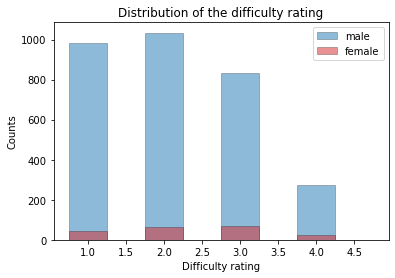

In [574]:
plot_2_dist("difficulty_rating", people_target_paths[people_target_paths["finished"] == True], bins=np.arange(1-0.25,5+0.25,0.5),
            my_title="Distribution of the difficulty rating", my_xlabel="Difficulty rating", my_ylabel="Counts")

#### **Link in Degree**

In [575]:
wlink_in = bootstrap_metric("nr_link_in", people, "female")
mlink_in = bootstrap_metric("nr_link_in", people, "male")

female: Geometric mean: 6.23063003703265
female: 95.0% confidence interval of the geometric mean of nr_link_in: [4.576, 8.704]
male: Geometric mean: 9.601510226110804
male: 95.0% confidence interval of the geometric mean of nr_link_in: [8.750, 10.504]


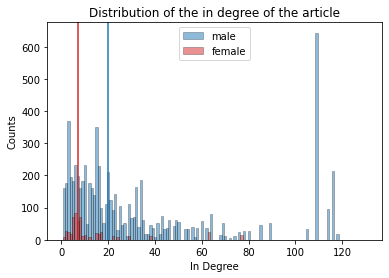

In [576]:
plot_2_dist("nr_link_in", people_target_paths,
            my_title="Distribution of the in degree of the article", my_xlabel="In Degree", my_ylabel="Counts")

### **Controlling for all confounding factors**

Now, we will create pairs of paths that we will compare. The target articles of the pairs are a women article and a man article. Both paths in every pair are either finished or unfinished, in other words, we do not pair a finished path with an unfinished one. (ATHATH)

#### **Matching**

In order to create the pairs, we need to match two target articles from the two groups of men and women articles. As mentioned in the README, the matching will be constrained by the following parameters:

1. starting a path at the same source article (minimum requirement of matching)
2. having the same shortest path length between a source article and a target article
3. having target articles in the same sub-category (e.g. male scientist vs. female scientist)
4. having target articles with a similiar or the same in_degree

The function `matching` matches two target articles from the control group (men) and from the treatment group (women) from our dataset. The `if`-statements handle each of the pre-defined constraints (from the minimum control to the strongest one). The function then returns three sets of four dataframes where each row corresponds to a path with a target article about a man or a woman with exactly one matched pair of the opposite gender. 

In [577]:
def matching():
    # 1) match on source
    # 2) match on source and same shortest path link
    # 3) match on category and above
    # 4) match on nr_link_in  --------------------------- NOTE DONE 

    finished = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]
    unfinished = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]
    all_paths = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]

    for control_id, control_row in men_target_paths.iterrows():
        for treatment_id, treatment_row in women_target_paths.iterrows():
            # Add an edge only if the paths are both finished
            if (control_row['finished'] == True and treatment_row['finished'] == True):
                
                # Add an edge only if the paths have the same source
                if (control_row['source'] == treatment_row['source']):
                    finished[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    # Add an edge only if the paths have the same shortest_path_length
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        finished[1].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        # Add an edge only if the paths have a target article within the same category
                        if (control_row['category'] == treatment_row['category']):
                            finished[2].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        elif (control_row['in_degree_rep'] == treatment_row['in_degree_rep']):
                            finished[3].add_weighted_edges_from([(control_id, treatment_id, 1)])
                            
            # Add an edge only if the paths are both unfinished
            if (control_row['finished'] == False and treatment_row['finished'] == False):
                
                # Add an edge only if the paths have the same source
                if (control_row['source'] == treatment_row['source']):
                    unfinished[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    # Add an edge only if the paths have the same shortest_path_length
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        unfinished[1].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        # Add an edge only if the paths have a target article within the same category
                        if (control_row['category'] == treatment_row['category']):
                            unfinished[2].add_weighted_edges_from([(control_id, treatment_id, 1)]) 
                        
                        elif (control_row['in_degree_rep'] == treatment_row['in_degree_rep']):
                            unfinished[3].add_weighted_edges_from([(control_id, treatment_id, 1)])
                            
            # Add an edge between all possible paths, unfinished and finished (??????????????'???????)               
            else:
                
                # Add an edge only if the paths have the same source
                if (control_row['source'] == treatment_row['source']):
                    all_paths[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    # Add an edge only if the paths have the same shortest_path_length
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        all_paths[1].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        
                        # Add an edge only if the paths have a target article within the same category
                        if (control_row['category'] == treatment_row['category']):
                            all_paths[2].add_weighted_edges_from([(control_id, treatment_id, 1)])
                        elif (control_row['in_degree_rep'] == treatment_row['in_degree_rep']):
                            all_paths[3].add_weighted_edges_from([(control_id, treatment_id, 1)])

    finished_dfs = []
    for g in finished:
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        finished_dfs.append(balanced_df_all)
        
    unfinished_dfs = []
    for g in unfinished:
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        unfinished_dfs.append(balanced_df_all)
    
    dfs = []
    for g in all_paths:
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        dfs.append(balanced_df_all)

    return finished_dfs, unfinished_dfs, dfs

In [578]:
# calculate success_rate for targets in their matching groups
# if target article only appears once, it will receive a NaN.  

def add_success_rate(df): 
    df = df.drop(columns = ["name"])
    fin = df[df['finished'] == True]["target"].value_counts().reindex(df.target.unique(), fill_value=0).rename("finished")
    tot = df["target"].value_counts().rename("total")

    temp=pd.concat([fin,tot],axis=1)
    temp.loc[temp["total"] > 1, 'success_rate'] = fin/tot

    success_rate = temp["success_rate"]
    # success_rate = success_rate.rename("success_rate")
    df = df.merge(success_rate, how="left", left_on="target", right_index=True)
    return df

In the following code cell, we call the function `matching` and save each returned dataframe to a file. We only do this once, since the function has a long run-time (which is the reason for why it is commented).

In [579]:

# finished_dfs, unfinished_dfs, dfs = matching()

# dfs = [add_success_rate(df) for df in dfs]
# finished_dfs= [add_success_rate(df) for df in finished_dfs]
# unfinished_dfs = [add_success_rate(df) for df in unfinished_dfs]

# source_matching = dfs[0]
# source_matching.to_csv("./data/source_matched.csv")
# fin_source_matching = finished_dfs[0]
# fin_source_matching.to_csv("./data/fin_source_matched.csv")
# unfin_source_matching = unfinished_dfs[0]
# unfin_source_matching.to_csv("./data/unfin_source_matched.csv")

# src_shp_match = dfs[1]
# src_shp_match.to_csv("./data/src_and_shp_matched.csv")
# fin_src_shp_match = finished_dfs[1]
# fin_src_shp_match.to_csv("./data/fin_src_and_shp_matched.csv")
# unfin_src_shp_match = unfinished_dfs[1]
# unfin_src_shp_match.to_csv("./data/unfin_src_and_shp_matched.csv")

# cat_and_rest = dfs[2]
# cat_and_rest.to_csv("./data/cat_and_rest_matched.csv")
# fin_cat_and_rest = finished_dfs[2]
# fin_cat_and_rest.to_csv("./data/fin_cat_and_rest_matched.csv")
# unfin_cat_and_rest = unfinished_dfs[2]
# unfin_cat_and_rest.to_csv("./data/unfin_cat_and_rest_matched.csv")

# degree_and_rest = dfs[3]
# degree_and_rest.to_csv("./data/degree_and_rest_matched.csv")
# fin_degree_and_rest = finished_dfs[3]
# fin_degree_and_rest.to_csv("./data/fin_degree_and_rest_matched.csv")
# unfin_degree_and_rest = unfinished_dfs[3]
# unfin_degree_and_rest.to_csv("./data/unfin_degree_and_rest_matched.csv")



Here, we import the data we just saved to a file. The following table gives an overview over the generated files of the matched data

| **Name of dataframe**      | **Matched paths and constraint parameters**                                                     |
|----------------------|---------------------------------------------------------------------|
| src_match               | All paths: (1)                                   |
| shpath_match               | All paths: (1), (2)                                    |
| cat_match             | All paths: (1), (2), (3)                          |
| fin_src_match    | Finished paths: (1) |
| fin_shpath_match | Finished paths: (1), (2)                    |
| fin_cat_match        | Finished paths: (1), (2), (3)                                                   |
| unfin_src_match    | Unfinished paths: (1) |
| unfin_shpath_match | Unfinished paths: (1), (2)                    |
| unfin_cat_match        | Unfinished paths: (1), (2), (3)                                                   |


In [580]:
src_match = pd.read_csv(DATA_FOLDER+"source_matched.csv").drop(columns = ['Unnamed: 0'])
shpath_match = pd.read_csv(DATA_FOLDER+"src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
cat_match = pd.read_csv(DATA_FOLDER+"cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])
degree_match = pd.read_csv(DATA_FOLDER+"degree_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])

fin_src_match = pd.read_csv(DATA_FOLDER+"fin_source_matched.csv").drop(columns = ['Unnamed: 0'])
fin_shpath_match = pd.read_csv(DATA_FOLDER+"fin_src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
fin_cat_match = pd.read_csv(DATA_FOLDER+"fin_cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])
fin_degree_match = pd.read_csv(DATA_FOLDER+"fin_degree_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])

unfin_src_match = pd.read_csv(DATA_FOLDER+"unfin_source_matched.csv").drop(columns = ['Unnamed: 0'])
unfin_shpath_match = pd.read_csv(DATA_FOLDER+"unfin_src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
unfin_cat_match = pd.read_csv(DATA_FOLDER+"unfin_cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])
unfin_degree_match = pd.read_csv(DATA_FOLDER+"unfin_degree_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])



The number of matched paths on each of our constraints can be seen in the following table and plot:

In [581]:
comb_source = len(src_match)
comb_source_f = len(fin_src_match)
comb_source_u = len(unfin_src_match)

comb_shpath = len(shpath_match)
comb_shpath_f = len(fin_shpath_match)
comb_shpath_u = len(unfin_shpath_match)

comb_category = len(cat_match)
comb_category_f = len(fin_cat_match)
comb_category_u = len(unfin_cat_match)

comb_degree = len(cat_match)
comb_degree_f = len(fin_degree_match)
comb_degree_u = len(unfin_degree_match)



d = {'combination': ['Control on source','Control on source and shortest path length', 
                    'Control on source, shortest path length and category', 
                    'Control on source, shortest path length and in degree'], 
    'all paths': [comb_source, comb_shpath, comb_category, comb_degree],
     'finished paths': [comb_source_f, comb_shpath_f, comb_category_f, comb_degree_f],
    'unfinished paths' : [comb_source_u, comb_shpath_u, comb_category_u, comb_degree_u]}

combinations = pd.DataFrame(data=d, index=[ 'source',
                                            'source and shortest path length', 
                                            'source, shortest path length and category', 
                                            'source, shortest path length and degree'])

In [582]:
combinations[['all paths','finished paths', 'unfinished paths']]

,all paths,finished paths,unfinished paths
source,572,286,114
source and shortest path length,306,158,50
"source, shortest path length and category",22,12,6
"source, shortest path length and degree",22,98,40


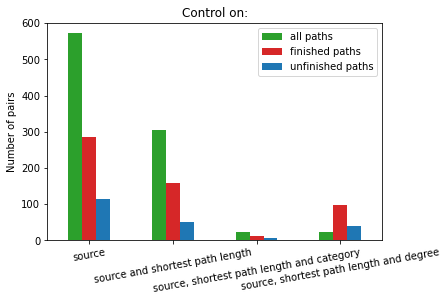

In [583]:
ax = combinations.plot.bar(rot=10, stacked = False, color = ['tab:green','tab:red', 'tab:blue'], 
                           title = "Control on:",
                           ylabel = "Number of pairs", width = 0.5)
plt.show()

#### **Controlled statistical analysis**

In [584]:
def linear_regression(column, dataframe, my_title="", my_xlabel = "", my_ylabel = ""):
    mod = smf.ols(f'{column} ~ gender', dataframe).fit()
    print(mod.summary())
    conf = mod.conf_int()
    mean_female = mod.params["Intercept"]
    mean_male = mean_female + mod.params["gender[T.male]"]
    uerr_female = conf.loc["Intercept"][1]-mean_female
    lerr_female = conf.loc["Intercept"][1]-mean_female
    uerr_male =  mean_male - (mean_female + conf.loc["gender[T.male]"][0])
    lerr_male =  mean_male- (mean_female + conf.loc["gender[T.male]"][0])
    error = np.array([[lerr_female, lerr_male], [uerr_female, uerr_male]])

    # Create lists for the plot
    genders = ['female', 'male']
    x_pos = np.arange(len(genders))
    medians = [mean_female, mean_male]

    fig, ax = plt.subplots()
    ax.bar(x_pos, medians, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(my_ylabel)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(genders)
    ax.set_title(my_title)
    ax.yaxis.grid(True)


    at = AnchoredText(f"pairs = {int(dataframe[column].size/2)}", loc='lower right', prop=dict(size=8), frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    # Save the figure and show
    # plt.tight_layout()
    plt.show()

In [585]:
def quantile_regression(column, dataframe, my_title="", my_xlabel = "", my_ylabel = ""):
    mod = smf.quantreg(f'{column} ~ gender', dataframe).fit(q=0.5)
    print(mod.summary())
    conf = mod.conf_int()
    median_female = mod.params["Intercept"]
    median_male = median_female + mod.params["gender[T.male]"]
    uerr_female = conf.loc["Intercept"][1]-median_female
    lerr_female = conf.loc["Intercept"][1]-median_female
    uerr_male =  median_male - (median_female + conf.loc["gender[T.male]"][0])
    lerr_male =  median_male- (median_female + conf.loc["gender[T.male]"][0])
    error = np.array([[lerr_female, lerr_male], [uerr_female, uerr_male]])

    # Create lists for the plot
    genders = ['female', 'male']
    x_pos = np.arange(len(genders))
    medians = [median_female, median_male]

    fig, ax = plt.subplots()
    ax.bar(x_pos, medians, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(my_ylabel)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(genders)
    ax.set_title(my_title)
    ax.yaxis.grid(True)


    at = AnchoredText(f"pairs = {int(dataframe[column].size/2)}", loc='lower right', prop=dict(size=8), frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    # Save the figure and show
    # plt.tight_layout()
    plt.show()

In [586]:
# src_match = add_success_rate(src_match)
# shpath_match = add_success_rate(shpath_match)
# cat_match = add_success_rate(cat_match)
# degree_match = add_success_rate(degree_match)


# fin_src_match = add_success_rate(fin_src_match)
# fin_shpath_match = add_success_rate(fin_shpath_match)
# fin_cat_match = add_success_rate(fin_cat_match)
# fin_degree_match = add_success_rate(fin_degree_match)

# unfin_src_match = add_success_rate(unfin_src_match)
# unfin_shpath_match = add_success_rate(unfin_shpath_match)
# unfin_cat_match = add_success_rate(unfin_cat_match)
# unfin_degree_match = add_success_rate(unfin_cat_match)

### **(1): Match on source**

| **Name of dataframe**      | **Matched paths and constraint parameters**                                                     |
|----------------------|---------------------------------------------------------------------|
| src_match               | All paths: (1)                                   |
| fin_src_match    | Finished paths: (1) |
| unfin_src_match    | Unfinished paths: (1) |

In [587]:
corr = src_match.corr()
corr.style.background_gradient(cmap='coolwarm')

,finished,human_path_length,shortest_path_length,path_deviation,playtime_sec,playtime_min,difficulty_rating,number_backclicks,timestamp,nr_link_in,in_degree_rep,success_rate
finished,1.000000,-0.085436,-0.311620,-0.044565,-0.480346,-0.480346,nan,-0.053893,-0.369186,0.269377,0.229620,0.748036
human_path_length,-0.085436,1.000000,0.220604,0.991034,0.333947,0.333947,0.493157,0.828877,0.079253,-0.186095,-0.177547,-0.194341
shortest_path_length,-0.311620,0.220604,1.000000,0.088308,0.237789,0.237789,0.267289,0.053281,0.133095,-0.476033,-0.437480,-0.423112
path_deviation,-0.044565,0.991034,0.088308,1.000000,0.308471,0.308471,0.471322,0.839194,0.062705,-0.124841,-0.121393,-0.141480
playtime_sec,-0.480346,0.333947,0.237789,0.308471,1.000000,1.000000,0.441637,0.321197,0.236073,-0.178207,-0.152201,-0.417379
playtime_min,-0.480346,0.333947,0.237789,0.308471,1.000000,1.000000,0.441637,0.321197,0.236073,-0.178207,-0.152201,-0.417379
difficulty_rating,nan,0.493157,0.267289,0.471322,0.441637,0.441637,1.000000,0.396423,-0.028897,-0.230665,-0.212498,-0.204390
number_backclicks,-0.053893,0.828877,0.053281,0.839194,0.321197,0.321197,0.396423,1.000000,0.046308,-0.112891,-0.110561,-0.123812
timestamp,-0.369186,0.079253,0.133095,0.062705,0.236073,0.236073,-0.028897,0.046308,1.000000,-0.041047,-0.006486,-0.353263
nr_link_in,0.269377,-0.186095,-0.476033,-0.124841,-0.178207,-0.178207,-0.230665,-0.112891,-0.041047,1.000000,0.982146,0.390955


Noticed correlations on `src_match`
- success_rate ~ finished: 0.8
- number_backclicks ~ path_deviation & human_path_length: 0.8
- human_path_length ~ path_deviation: 0.99
- playtime ~ difficulty_rating: 0.45

#### **Success rate**

In [588]:
src_match_summary = pd.DataFrame(data=[], columns=["metric","gender", "gmean", "ci_0", "ci_1"])

In [589]:
# ALL PATHS matched
src_match_summary =bootstrap_metric("success_rate", src_match, "female", summary=src_match_summary)
src_match_summary =bootstrap_metric("success_rate", src_match, "male", summary=src_match_summary)

female: Geometric mean: 0.4638913702442112
female: 95.0% confidence interval of the geometric mean of success_rate: [0.416, 0.512]
male: Geometric mean: 0.8710690904118007
male: 95.0% confidence interval of the geometric mean of success_rate: [0.832, 0.905]


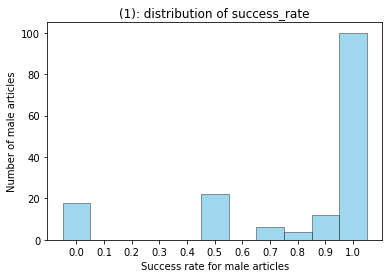

In [590]:
male = src_match[src_match["gender"]== "male"]["success_rate"]
# plot the histogram
plt.hist(male, color = 'skyblue', bins = np.arange(0-0.05,1+0.15,0.1),edgecolor = 'black', linewidth = 0.5, alpha=0.8)
plt.xlabel("Success rate for male articles")
plt.ylabel("Number of male articles")
plt.xticks(np.arange(0,1.1,0.1))
plt.title("(1): distribution of success_rate")
plt.show()

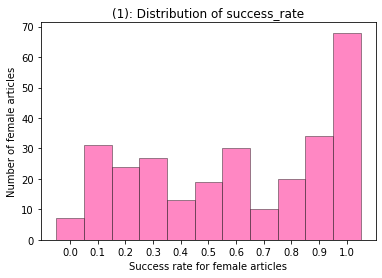

In [591]:
female = src_match[src_match["gender"]== "female"]["success_rate"]
# plot the histogram
plt.hist(female, color = 'hotpink',bins= np.arange(0-0.05,1+0.15,0.1), edgecolor = 'black', linewidth = 0.5, alpha=0.8)
plt.xlabel("Success rate for female articles")
plt.ylabel("Number of female articles")
plt.xticks(np.arange(0,1.1,0.1))
plt.title("(1): Distribution of success_rate")
plt.show()

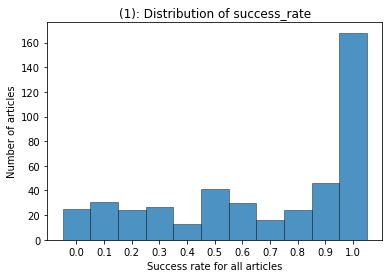

In [592]:
# plot the histogram
plt.hist(src_match["success_rate"], color = 'tab:blue',bins= np.arange(0-0.05,1+0.15,0.1), edgecolor = 'black', linewidth = 0.5, alpha=0.8)
plt.xlabel("Success rate for all articles")
plt.ylabel("Number of articles")
plt.xticks(np.arange(0,1.1,0.1))
plt.title("(1): Distribution of success_rate")
plt.show()

#### **Playtime**

In [593]:
# FINISHED PATHS matched
src_match_summary = bootstrap_metric("playtime_min", fin_src_match, "female", summary=src_match_summary)
src_match_summary = bootstrap_metric("playtime_min", fin_src_match, "male", summary=src_match_summary)

female: Geometric mean: 2.3423288471044947
female: 95.0% confidence interval of the geometric mean of playtime_min: [2.027, 2.690]
male: Geometric mean: 1.5417810224667179
male: 95.0% confidence interval of the geometric mean of playtime_min: [1.324, 1.771]


#### **Path deviation**

In [594]:
# FINISHED PATHS matched
src_match_summary= bootstrap_metric("path_deviation", fin_src_match, "female", ci=0.9, summary=src_match_summary)
src_match_summary= bootstrap_metric("path_deviation", fin_src_match, "male", ci=0.9, summary= src_match_summary)

female: Geometric mean: 2.868222434338483
female: 90.0% confidence interval of the geometric mean of path_deviation: [2.568, 3.230]
male: Geometric mean: 2.28099895895486
male: 90.0% confidence interval of the geometric mean of path_deviation: [2.065, 2.542]


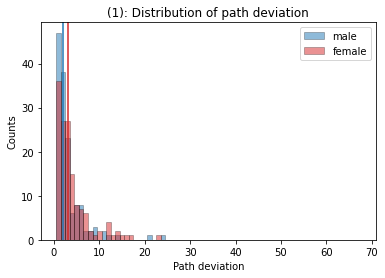

In [595]:
plot_2_dist("path_deviation", fin_src_match, 
            my_title="(1): Distribution of path deviation", my_xlabel="Path deviation", 
            my_ylabel="Counts")

#### **Number of back clicks**

In [596]:
# FINISHED PATHS matched
src_match_summary= bootstrap_metric("number_backclicks", src_match, "female", ci=0.9, summary= src_match_summary)
src_match_summary= bootstrap_metric("number_backclicks", src_match, "male", ci=0.9, summary= src_match_summary)

female: Geometric mean: 1.7572296754332428
female: 90.0% confidence interval of the geometric mean of number_backclicks: [1.533, 2.069]
male: Geometric mean: 1.8083328980338347
male: 90.0% confidence interval of the geometric mean of number_backclicks: [1.560, 2.163]


#### **Difficulty rating**

In [597]:
# FINISHED PATHS matched
src_match_summary= bootstrap_metric("difficulty_rating", fin_src_match, "female", ci=0.9, summary=src_match_summary)
src_match_summary = bootstrap_metric("difficulty_rating", fin_src_match, "male", ci=0.9, summary = src_match_summary)

female: Geometric mean: 2.1461710335086894
female: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.970, 2.324]
male: Geometric mean: 1.916266300686311
male: 90.0% confidence interval of the geometric mean of difficulty_rating: [1.748, 2.110]


<AxesSubplot:xlabel='metric', ylabel='gmean'>

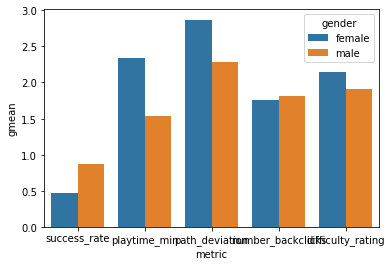

In [598]:
sns.barplot(data=src_match_summary, x="metric", y= "gmean", hue="gender")

In [599]:
src_match_summary["plus_error"] = src_match_summary["ci_1"] - src_match_summary["gmean"]
src_match_summary["minus_error"] = src_match_summary["gmean"]- src_match_summary["ci_0"]

In [673]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='female',
    x=src_match_summary[src_match_summary["gender"] =="female"]["metric"],
    y=src_match_summary[src_match_summary["gender"] =="female"]["gmean"],
    error_y=dict(type='data', 
                array=src_match_summary[src_match_summary["gender"] =="female"]["plus_error"],
                arrayminus=src_match_summary[src_match_summary["gender"] =="female"]["minus_error"]
                ),
    marker=dict(color=["hotpink", "hotpink", "hotpink", "hotpink", "hotpink"],opacity=[1,1,1,0.4,0.4])  
    
    
))
fig.add_trace(go.Bar(
    name='male',
    x=src_match_summary[src_match_summary["gender"] =="male"]["metric"],
    y=src_match_summary[src_match_summary["gender"] =="male"]["gmean"],
    error_y=dict(type='data',
                array=src_match_summary[src_match_summary["gender"] =="male"]["plus_error"],
                arrayminus=src_match_summary[src_match_summary["gender"] =="male"]["minus_error"]),
    marker=dict(color=["skyblue", "skyblue", "skyblue", "skyblue", "skyblue"],opacity=[1,1,1,0.4,0.4])  
))
fig.update_layout(  barmode='group', template = "simple_white",
                    title="Comparison of the geometric mean of different metrics ",
                    xaxis_title="Metrics",
                    yaxis_title="Geometric Mean",
                    legend_title = "Gender",
                    font=dict(
                        family="Times New Roman, serif",
                        size=13,
                        color="#404040"
                        ))
fig.show()

In [672]:
src_match_summary

,metric,gender,gmean,ci_0,ci_1,plus_error,minus_error
0,success_rate,female,0.463891,0.415524,0.511749,0.047858,0.048368
1,success_rate,male,0.871069,0.832397,0.904558,0.033489,0.038672
2,playtime_min,female,2.342329,2.027059,2.689874,0.347545,0.31527
3,playtime_min,male,1.541781,1.32443,1.770891,0.22911,0.217351
4,path_deviation,female,2.868222,2.568488,3.229942,0.361719,0.299735
5,path_deviation,male,2.280999,2.065383,2.542014,0.261015,0.215616
6,number_backclicks,female,1.75723,1.532594,2.068589,0.311359,0.224636
7,number_backclicks,male,1.808333,1.559624,2.16295,0.354617,0.248709
8,difficulty_rating,female,2.146171,1.9695,2.323956,0.177785,0.176671
9,difficulty_rating,male,1.916266,1.747791,2.110429,0.194162,0.168475


### **(1)+(2): Match on source and shortest path length**

| **Name of dataframe**      | **Matched paths and constraint parameters**                                                     |
|----------------------|---------------------------------------------------------------------|
| shpath_match               | All paths: (1)                                   |
| fin_shpath_match    | Finished paths: (1) |
| unfin_shpath_match    | Unfinished paths: (1) |

#### **Success rate**

In [601]:
# ALL PATHS matched
bootstrap_metric("success_rate", shpath_match, "female", ci=0.9)
bootstrap_metric("success_rate", shpath_match, "male", ci=0.9)

female: Geometric mean: 0.5876958125740577
female: 90.0% confidence interval of the geometric mean of success_rate: [0.534, 0.638]
male: Geometric mean: 0.9248881014491848
male: 90.0% confidence interval of the geometric mean of success_rate: [0.877, 0.954]


""


                         QuantReg Regression Results                          
Dep. Variable:           success_rate   Pseudo R-squared:               0.1549
Model:                       QuantReg   Bandwidth:                      0.2844
Method:                 Least Squares   Sparsity:                       0.8337
Date:                Wed, 21 Dec 2022   No. Observations:                  219
Time:                        11:32:37   Df Residuals:                      217
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6667      0.035     19.192      0.000       0.598       0.735
gender[T.male]     0.3333      0.059      5.616      0.000       0.216       0.450


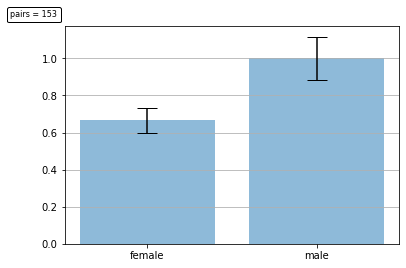

In [602]:
quantile_regression("success_rate", shpath_match)

#### **playtime**

In [603]:
# FINISHED PATHS matched
bootstrap_metric("playtime_min", fin_shpath_match, "female")

bootstrap_metric("playtime_min", fin_shpath_match, "male")

female: Geometric mean: 2.2146861069353587
female: 95.0% confidence interval of the geometric mean of playtime_min: [1.873, 2.647]
male: Geometric mean: 1.7819621794695775
male: 95.0% confidence interval of the geometric mean of playtime_min: [1.510, 2.131]


""


#### **Path deviation**

In [604]:
# FINISHED PATHS matched
bootstrap_metric("path_deviation", fin_shpath_match, "female")

bootstrap_metric("path_deviation", fin_shpath_match, "male")

female: Geometric mean: 2.664617066028386
female: 95.0% confidence interval of the geometric mean of path_deviation: [2.280, 3.157]
male: Geometric mean: 2.3869054293062617
male: 95.0% confidence interval of the geometric mean of path_deviation: [2.047, 2.844]


""


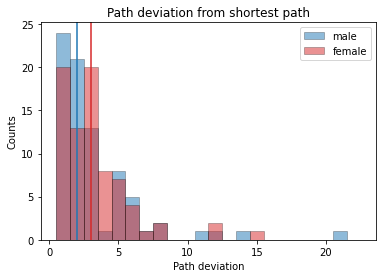

In [605]:
plot_2_dist("path_deviation", fin_shpath_match, 
            my_title="Path deviation from shortest path", my_xlabel="Path deviation", my_ylabel="Counts")

                            OLS Regression Results                            
Dep. Variable:         path_deviation   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.2722
Date:                Wed, 21 Dec 2022   Prob (F-statistic):              0.603
Time:                        11:32:38   Log-Likelihood:                -414.43
No. Observations:                 158   AIC:                             832.9
Df Residuals:                     156   BIC:                             839.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5696      0.377      9.

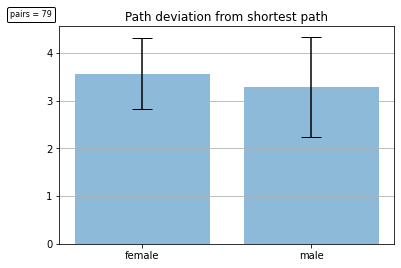

In [606]:
linear_regression("path_deviation", fin_shpath_match, "Path deviation from shortest path")

This data shows that out of finished paths that have the same source article and the same shortest path length, the ones going to the male target article have a median of 2 path_dev while the female target articles have a median of 3. However the confidence intervals overlap, so we cannot say for sure that the difference is significant.

#### **Number of back clicks**

In [607]:
# ALL PATHS matched
bootstrap_metric("number_backclicks", shpath_match, "female")

bootstrap_metric("number_backclicks", shpath_match, "male")

female: Geometric mean: 1.742575776141812
female: 95.0% confidence interval of the geometric mean of number_backclicks: [1.444, 2.283]
male: Geometric mean: 1.972526648610801
male: 95.0% confidence interval of the geometric mean of number_backclicks: [1.522, 2.752]


""


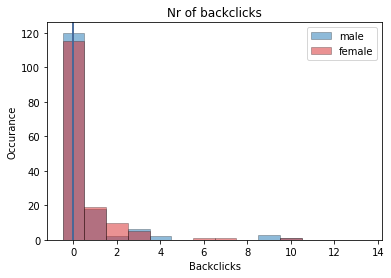

In [608]:
plot_2_dist("number_backclicks", shpath_match, my_title="Nr of backclicks", my_xlabel="Backclicks", my_ylabel="Occurance")

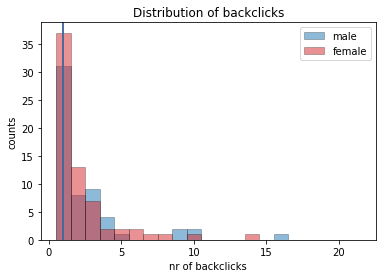

In [609]:
# the backclicks that differ from 0
backclicks = src_match[src_match["number_backclicks"]!= 0]
plot_2_dist("number_backclicks", backclicks, 
            my_title="Distribution of backclicks", my_xlabel="nr of backclicks", my_ylabel="counts")

#### **Difficulty rating**

In [610]:
# FINISHED PATHS matched
bootstrap_metric("difficulty_rating", fin_shpath_match, "female")
bootstrap_metric("difficulty_rating", fin_shpath_match, "male")

female: Geometric mean: 1.9544654848281908
female: 95.0% confidence interval of the geometric mean of difficulty_rating: [1.703, 2.200]
male: Geometric mean: 2.0654610525799098
male: 95.0% confidence interval of the geometric mean of difficulty_rating: [1.759, 2.416]


""


### **(1)+(2)+(3): Match on source, shortest path length and categories**

| **Name of dataframe**      | **Matched paths and constraint parameters**                                                     |
|----------------------|---------------------------------------------------------------------|
| cat_match               | All paths: (1)                                   |
| fin_cat_match    | Finished paths: (1) |
| unfin_cat_match    | Unfinished paths: (1) |


#### **Success rate**

In [611]:
# # ALL PATHS matched
# bootstrap_metric("success_rate", cat_match, "female", estimator= "Median", remove_zero=True)
# bootstrap_metric("success_rate", cat_match, "male",estimator= "Median", remove_zero=True)

#### **Playtime**

In [612]:
# FINISHED PATHS matched
bootstrap_metric("playtime_min", fin_cat_match, "female")
bootstrap_metric("playtime_min", fin_cat_match, "male")

female: Geometric mean: 3.9567849447628056
female: 95.0% confidence interval of the geometric mean of playtime_min: [1.398, 15.438]
male: Geometric mean: 1.9771218887790076
male: 95.0% confidence interval of the geometric mean of playtime_min: [1.279, 3.523]


""


#### **Path deviation**

In [613]:
# FINISHED PATHS matched
bootstrap_metric("path_deviation", fin_cat_match, "female")

bootstrap_metric("path_deviation", fin_cat_match, "male")

female: Geometric mean: 2.6960123091945554
female: 95.0% confidence interval of the geometric mean of path_deviation: [1.260, 4.160]
male: Geometric mean: 1.8171205928321397
male: 95.0% confidence interval of the geometric mean of path_deviation: [1.122, 3.147]


""


| **Name of dataframe**      | **Matched paths and constraint parameters**                                                     |
|----------------------|---------------------------------------------------------------------|
| cat_match               | All paths: (1)                                   |
| fin_cat_match    | Finished paths: (1) |
| unfin_cat_match    | Unfinished paths: (1) |

#### **Number of back clicks**

In [614]:
# # ALL PATHS matched
# bootstrap_metric("number_backclicks", cat_match, "female")
# # 
# bootstrap_metric("number_backclicks", cat_match, "male")

#### **Difficulty rating**

In [615]:
# FINISHED PATHS matched
bootstrap_metric("difficulty_rating", fin_cat_match, "female")

bootstrap_metric("difficulty_rating", fin_cat_match, "male")

female: Geometric mean: 1.8171205928321397
female: 95.0% confidence interval of the geometric mean of difficulty_rating: [1.000, 2.621]
male: Geometric mean: 2.352158045049347
male: 95.0% confidence interval of the geometric mean of difficulty_rating: [1.246, 3.178]


""


### **(1)+(2)+(4): Match on source, shortest path length and in degree**

| **Name of dataframe**      | **Matched paths and constraint parameters**                                                     |
|----------------------|---------------------------------------------------------------------|
| degree_match               | All paths: (1)+(2)+(4)                                |
| fin_degree_match    | Finished paths: (1)+(2)+(4) |
| unfin_degree_match    | Unfinished paths: (1)+(2)+(4) |


#### **Success rate**

In [616]:
# ALL PATHS matched
bootstrap_metric("success_rate", degree_match, "female")
bootstrap_metric("success_rate", degree_match, "male")

female: Geometric mean: 0.5695552949267243
female: 95.0% confidence interval of the geometric mean of success_rate: [0.503, 0.632]
male: Geometric mean: 0.9186269540704759
male: 95.0% confidence interval of the geometric mean of success_rate: [0.832, 0.958]


""


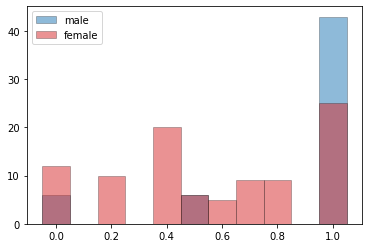

In [617]:
plot_2_dist("success_rate", degree_match,np.arange(0-0.05,1+0.15,0.1))

#### **Playtime**

In [620]:
# FINISHED PATHS matched
bootstrap_metric("playtime_min", fin_degree_match, "female")
bootstrap_metric("playtime_min", fin_degree_match, "male")

female: Geometric mean: 2.4966532110486086
female: 95.0% confidence interval of the geometric mean of playtime_min: [2.011, 3.114]
male: Geometric mean: 2.2401291478161554
male: 95.0% confidence interval of the geometric mean of playtime_min: [1.798, 2.803]


""


#### **Path deviation**


In [621]:
# FINISHED PATHS matched
bootstrap_metric("path_deviation", fin_degree_match, "female")
bootstrap_metric("path_deviation", fin_degree_match, "male")

female: Geometric mean: 2.7815231004758134
female: 95.0% confidence interval of the geometric mean of path_deviation: [2.253, 3.524]
male: Geometric mean: 3.0894217828337016
male: 95.0% confidence interval of the geometric mean of path_deviation: [2.517, 3.822]


""


#### **Number of back clicks**

In [622]:
# FINISHED PATHS matched
bootstrap_metric("number_backclicks", degree_match, "female")

bootstrap_metric("number_backclicks", degree_match, "male")

female: Geometric mean: 1.6940612677841544
female: 95.0% confidence interval of the geometric mean of number_backclicks: [1.363, 2.316]
male: Geometric mean: 2.2106664570866146
male: 95.0% confidence interval of the geometric mean of number_backclicks: [1.602, 3.275]


""


#### **Difficulty rating**

In [623]:
# FINISHED PATHS matched
bootstrap_metric("difficulty_rating", degree_match, "female")

bootstrap_metric("difficulty_rating", degree_match, "male")

female: Geometric mean: 2.0801128417156494
female: 95.0% confidence interval of the geometric mean of difficulty_rating: [1.749, 2.423]
male: Geometric mean: 2.315523756903526
male: 95.0% confidence interval of the geometric mean of difficulty_rating: [2.007, 2.637]


""


### **Visualizations for the datastory**

#### **Plot 1**

In [625]:
# total_people = nr_men_women['number_of'].sum()
# nr_men_women['percentage'] = nr_men_women['number_of']/total_people*100
# nr_men_women['percentage'] = nr_men_women['percentage'].round(2)
# fig = go.Figure(data=[go.Scatter(
#     x=nr_men_women['x_value_to_align'], y=nr_men_women['y_value_to_align'],
#     text=nr_men_women['number_of'],
#     mode='markers+text',
#     marker=dict(
#         color=['hotpink', 'skyblue'],
#         opacity=[1, 1],
#         size=[nr_of_women, nr_of_men/2]),
#     hovertemplate=
#         "Articles about "+nr_men_women['gender']+" are " + ""+nr_men_women['percentage'].astype(str)+"%" +" of all articles about People"+ "",)])

# fig.update_layout(
#     font_family="Arial",
#     font_color="white",
#     font_size=20,
#     template = 'simple_white',
#     width=600, height=500
# )

# fig.update_xaxes(visible=False)   
# fig.update_yaxes(visible=False)
# fig.show()

# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/plot1.html", full_html=False, include_plotlyjs='cdn')
# #nr_men_women

#### **Plot 2**

In [627]:
# women_count = people[people['gender'] == "female"]["category"].count()
# men_count = people[people['gender'] == "male"]["category"].count()
# number_of_people_per_cat = people.groupby("category")["gender"].count()
# men_women_proportion = pd.DataFrame({'women': women_people/number_of_people_per_cat,'men': men_people/number_of_people_per_cat}, index=index).sort_values(by = ["women"], ascending = False)
# men_women_proportion.fillna(0,inplace=True)

# fig = px.bar(men_women_proportion, x='women')

# # plotly
# fig = px.bar(men_women_proportion, 
#              x = [category for category in men_women_proportion.columns],
#              y = men_women_proportion.transpose().columns.str.replace('_', ' '),
#              color_discrete_sequence = ['hotpink','skyblue'],
#              title = 'Fraction of women and men articles within each category',
#              labels={"y": "Categories",
#                      "value": "Proportion of articles",
#                      "variable": "Gender"},
#              orientation='h',
#              width=1000, height=600,
#             template = 'simple_white')
# fig.update_layout(yaxis=dict(autorange="reversed"))
# fig.show()

# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/plot2.html", full_html=False, include_plotlyjs='cdn')

#### **Plot 3**

In [629]:
# categories = men_women_cat.index.str.replace('_', ' ')
# men = men_women_cat['men'].values
# women = men_women_cat['women'].values
# women[np.isnan(women)] = 0
# total = men + women

# m = pd.DataFrame({'category': categories, 'amount': men,'gender': 'men'})
# w = pd.DataFrame({'category': categories, 'amount':women, 'gender':'women'})
# t = pd.concat([m, w])

# order_yaxis = men_women_proportion.transpose().columns.str.replace('_', ' ')
# order_yaxis = order_yaxis.append(order_yaxis)

# fig = px.bar(t, y=order_yaxis, x='amount', color='gender', barmode='group', 
#              color_discrete_sequence = ['skyblue', 'hotpink'], 
#              title = 'Number of women and men articles within each category',
#              labels={"y": "Categories",
#                     "amount": "Number of articles",
#                     "gender": "Gender"},
#              orientation='h',
#              width=1000, height=600,
#              template = 'simple_white')

# fig.update_layout(yaxis=dict(autorange="reversed"))
# fig.update_layout(yaxis=dict(autorange="reversed"))
# fig.show()

# fig.to_html(full_html = False, include_plotlyjs='cdn')
# fig.write_html("datastory_plot/plot3.html", full_html=False, include_plotlyjs='cdn')

#### **Plot 4**

In [630]:
# Radar chart for naive analysis - Can't show in jupyter notebook but on the webpage
# TODO decide how to do with playtime since that value scews the entire plot now.
# color code: https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

categories = ['Success Rate','Playtime','Path Deviation',
              'Difficulty Rating']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[wsuccessrate_mean, wplaytime_mean/100.0, wpathdev_mean, wdiffrating_mean],
      theta=categories,
      fill='toself',
      line_color='hotpink',
      name='Women'
))
fig.add_trace(go.Scatterpolar(
      r=[msuccessrate_mean, mplaytime_mean/100.0, mpathdev_mean, mdiffrating_mean],
      theta=categories,
      fill='toself',
      line_color='skyblue',
      name='Men'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 4]
    )),
  showlegend=False
)

fig.show()
#fig.to_html(full_html = False, include_plotlyjs='cdn')
#fig.write_html("datastory_plot/radarplot_test.html", full_html=False, include_plotlyjs='cdn')

In [631]:
df = pd.DataFrame([[women/(women+men),women_finished/(women_finished+men_finished),women_unfinished/(women_unfinished+men_unfinished)],
                   [men/(women+men),men_finished/(women_finished+men_finished),men_unfinished/(women_unfinished+men_unfinished)]], 
                  columns=["All paths", "Finished paths", "Unfinished paths"], index=["women", "men"])

In [632]:
df = pd.DataFrame([[women,women_finished,women_unfinished],
                   [men,men_finished,men_unfinished]], 
                  columns=["All paths", "Finished paths", "Unfinished paths"], index=["women", "men"])

In [634]:
src_match["success_rate"].value_counts()

1.000000    168
0.064516     31
0.500000     30
0.333333     27
0.000000     25
0.882353     17
0.615385     13
0.153846     13
0.916667     12
0.454545     11
0.181818     11
0.600000     10
0.666667      9
0.888889      9
0.777778      9
0.875000      8
0.375000      8
0.714286      7
0.571429      7
0.833333      6
0.400000      5
0.800000      5
0.750000      4
Name: success_rate, dtype: int64

In [636]:
bin_labels = ['fast', 'average','slow']
src_match['playtime_cat'] = pd.qcut(src_match['playtime_min'], q=3,
                              labels=bin_labels)


In [637]:


fig= px.scatter(src_match, x="gender", y="success_rate",color= "playtime_cat")
# fig = px.scatter_3d(src_match, x="gender", y="playtime", z= "success_rate", color= "gender")
fig.show()

In [638]:
src_match

,source,target,finished,human_path_length,shortest_path_length,path_deviation,playtime_sec,playtime_min,type,failure_article,difficulty_rating,number_backclicks,hashedIpAddress,timestamp,category,gender,nr_link_in,in_degree_rep,success_rate,playtime_cat
0,Badminton,J._K._Rowling,False,5,3,2,102,1.700000,restart,<,NaN,1,372bf51e197303b6,1366389652,Writers_and_critics,female,5,1,0.777778,average
1,Humanism,Tiger_Woods,False,11,3,8,2076,34.600000,timeout,Buddhism,NaN,4,052ba30a41ff5a05,1371789671,Sports_and_games_people,male,3,1,0.000000,slow
2,Sistine_Chapel_ceiling,Fidel_Castro,True,7,3,4,114,1.900000,NaN,NaN,NaN,1,71232b4d22d1a48e,1261527185,Political_People,male,23,2,1.000000,average
3,Acid_rain,Abraham_Lincoln,True,11,2,9,121,2.016667,NaN,NaN,2.0,1,50f8cac41862173b,1304241246,USA_Presidents,male,62,3,1.000000,average
4,Indira_Gandhi,Pete_Sampras,True,5,3,2,64,1.066667,NaN,NaN,NaN,0,473d6ac602c2b198,1316727999,Sports_and_games_people,male,13,1,NaN,fast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Dundee,Elizabeth_I_of_England,True,4,3,1,244,4.066667,NaN,NaN,2.0,0,0ded1e040a8df44d,1248278863,Monarchs_of_Great_Britain,female,63,3,0.882353,slow
568,Christmas_Island,William_Pitt_the_Younger,True,8,3,5,143,2.383333,NaN,NaN,NaN,0,1f5b881869546e6c,1388607976,Political_People,male,11,1,NaN,average
569,Democratic_Action_Party,Diane_Keaton,False,8,5,3,381,6.350000,restart,Film,NaN,0,212a2df726e3c8ec,1370628775,Actors_models_and_celebrities,female,2,1,0.153846,slow
570,Domestic_goat,Elizabeth_I_of_England,True,6,3,3,74,1.233333,NaN,NaN,2.0,0,0e803bd129b81574,1345146082,Monarchs_of_Great_Britain,female,63,3,0.882353,fast


In [639]:
test_articles = src_match.groupby("target").mean()
test_articles = test_articles.merge(src_match[["target", "gender"]], how="left", left_index=True, right_on="target")

In [641]:
fig = px.scatter(test_articles, x="playtime_min", y="success_rate", hover_name="target", color="gender", log_x=True, size_max=60)
fig.show()

<AxesSubplot:xlabel='gender', ylabel='success_rate'>

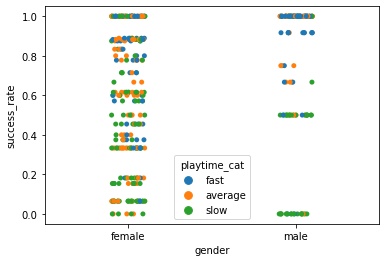

In [642]:
sns.stripplot(data=src_match, x="gender", y="success_rate", hue="playtime_cat")

<AxesSubplot:xlabel='success_rate', ylabel='playtime_cat'>

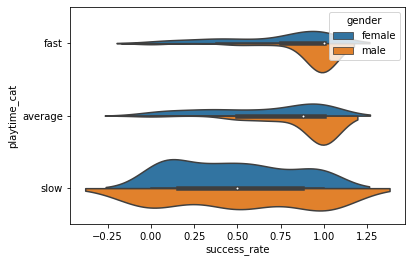

In [643]:
sns.violinplot(data=src_match, x="success_rate", y="playtime_cat", hue="gender", split=True)

In [644]:
fig = px.violin(src_match, y="playtime_cat", x="success_rate", color="gender",
          hover_data=src_match.columns)
fig.show()

In [645]:
# 12 sets of normal distributed random data, with increasing mean and standard deviation
import plotly.graph_objects as go
from plotly.colors import n_colors
import numpy as np
data = (np.linspace(1, 2, 12)[:, np.newaxis] * np.random.randn(12, 200) +
            (np.arange(12) + 2 * np.random.random(12))[:, np.newaxis])

colors = n_colors('rgb(5, 200, 200)', 'rgb(200, 10, 10)', 12, colortype='rgb')

fig = go.Figure()
for data_line, color in zip(data, colors):
    fig.add_trace(go.Violin(x=data_line, line_color=color))
    

fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)
fig.show()

In [646]:
layout = go.Layout(
    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    ), 
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig = go.Figure(layout=layout)

fig.add_trace(go.Violin(x=src_match['playtime_cat'][src_match['gender'] == 'female'],
                        y=src_match['success_rate'][src_match['gender'] == 'female' ],
                        legendgroup='female', 
                        scalegroup='female', name='female',
                        side='negative',
                        line_color='hotpink', 
                        span =[0, 1], spanmode = 'manual',
                        points=False)
             )
fig.add_trace(go.Violin(x=src_match['playtime_cat'][src_match['gender'] == 'male'],
                        y=src_match['success_rate'][src_match['gender'] == 'male'],
                        legendgroup='male', 
                        scalegroup='male', name='male',
                        side='positive',
                        line_color='skyblue',
                        span =[0, 1],spanmode = 'manual', 
                        points=False)
             )
fig.update_traces(meanline_visible=True)
fig.update_xaxes(categoryorder='array', categoryarray= ['slow', 'average', 'fast'])
fig.update_layout(margin=dict(l=20, r=20, t=20, b=20),
                    yaxis_range=[-0.1,1.1], autosize=False, width=1000, height=600, )
fig.show()

In [647]:
fig = go.Figure(layout=layout)
fig = px.box(src_match,x="gender",y="success_rate")
fig.show()